In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import pylibcam
import pyelas
import cv2
import pylab as pl
import numpy as np
import os
import sys
import time

In [3]:
import time

def save_as_png(img, base_dir, current_id, cam):
    file_name = '%s_%2.2d.jpg'%(cam, current_id)
    fqn = os.path.join(base_dir, file_name)
    cv2.imwrite(fqn, img)
    print "Saved image to " + fqn

def grab_images(chessboard_dimensions,  n=20, base_dir='/home/karthik/tmp/images' ):
    cam_1 = pylibcam.PyCamera('/dev/video1', 640, 480, 5)
    cam_2 = pylibcam.PyCamera('/dev/video2', 640, 480, 5)

    try:
        cam_1.setExposure(1)
        cam_2.setExposure(1)
        cam_1.setBrightness(1)
        cam_2.setBrightness(1)
        for i in range(4):
            time.sleep(2)
            cam_1.update(25,1000)
            cam_2.update(25,1000)

        attempt = 0
        current_id = 0
        while current_id < 20:
            attempt+=1
            time.sleep(2)
            cam_1.update(25,1000)
            cam_2.update(25,1000)
            img_1 = cam_1.toRGB()
            img_2 = cam_2.toRGB()
            gray_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
            gray_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
            ret_1, corners_1 = cv2.findChessboardCorners(gray_1, chessboard_dimensions,None)
            ret_2, corners_2 = cv2.findChessboardCorners(gray_1, chessboard_dimensions,None)
            if ret_1 and ret_2:
                save_as_png(img_1, base_dir, current_id, 'right')
                save_as_png(img_2, base_dir, current_id, 'left')
                current_id+=1
            else:
                print "Chessboard not found in attempt %d" % attempt
    finally:
        cam_1.StopCam()
        cam_2.StopCam()


In [5]:
grab_images((7,4))

Chessboard not found in attempt 1
Saved image to /home/karthik/tmp/images/right_00.jpg
Saved image to /home/karthik/tmp/images/left_00.jpg
Saved image to /home/karthik/tmp/images/right_01.jpg
Saved image to /home/karthik/tmp/images/left_01.jpg
Saved image to /home/karthik/tmp/images/right_02.jpg
Saved image to /home/karthik/tmp/images/left_02.jpg
Saved image to /home/karthik/tmp/images/right_03.jpg
Saved image to /home/karthik/tmp/images/left_03.jpg
Saved image to /home/karthik/tmp/images/right_04.jpg
Saved image to /home/karthik/tmp/images/left_04.jpg
Saved image to /home/karthik/tmp/images/right_05.jpg
Saved image to /home/karthik/tmp/images/left_05.jpg
Saved image to /home/karthik/tmp/images/right_06.jpg
Saved image to /home/karthik/tmp/images/left_06.jpg
Saved image to /home/karthik/tmp/images/right_07.jpg
Saved image to /home/karthik/tmp/images/left_07.jpg


KeyboardInterrupt: 

In [3]:
import sys
sys.path.append("/home/karthik/code/pyrobo/vision/")
sys.path.append("/home/karthik/code/StereoVision/")

In [4]:
from stereo import calibration
sc = calibration.StereoCalibrator(4, 7, 3, (640, 480))
base_dir = '/home/karthik/tmp/images/'
#for i in [2,7, 15, 19]:
for i in range(2,20):
    if i==5 or i==14:
        continue
    left_file_name = '%s_%2.2d.jpg'%("left", i)
    right_file_name = '%s_%2.2d.jpg'%("right", i)
    left = cv2.imread(os.path.join(base_dir, left_file_name))
    right = cv2.imread(os.path.join(base_dir, right_file_name))
    left_gray = cv2.cvtColor(left,cv2.COLOR_RGB2BGR)
    right_gray = cv2.cvtColor(right,cv2.COLOR_RGB2BGR)
    sc.add_corners((left,right), False)
    print i
cb = sc.calibrate_cameras()   
avg_error = sc.check_calibration(cb)    
print avg_error
#res_1, res_2 = cb.rectify([img_2, img_1])
#pl.imshow(res_1)

2
3
4
6
7
8
9
10
11
12
13
15
16
17
18
19
1.71093273081


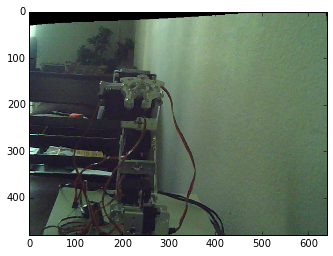

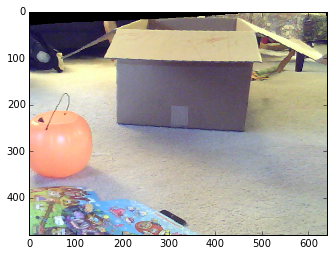

In [22]:
pl.imshow(right)

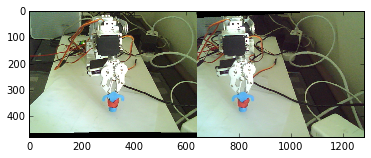

In [11]:
cam_1 = pylibcam.PyCamera('/dev/video1', 640, 480, 5)
cam_2 = pylibcam.PyCamera('/dev/video2', 640, 480, 5)
# cam_1.setExposure(1)
# cam_2.setExposure(1)
cam_1.setBrightness(1)
cam_2.setBrightness(1)
for i in range(4):
    time.sleep(2)
    cam_1.update(25,1000)
    cam_2.update(25,1000)
cam_1.update(25,1000)
cam_2.update(25,1000)
img_1 = cam_1.toRGB()
img_2 = cam_2.toRGB()
cam_1.StopCam()
cam_2.StopCam()
left, right = cb.rectify([img_2, img_1])
img = np.zeros((480, 640*2, 3), dtype=img_1.dtype)
img[:,:640,:] = left
img[:,640:,:] = right
pl.imshow(img)

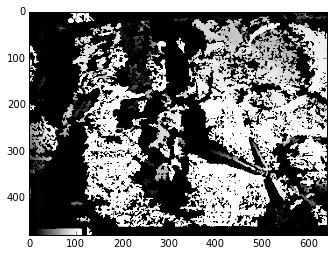

In [12]:
sys.path.append('/home/karthik/code/StereoVision/stereovision/')
from blockmatchers import StereoSGBM
bm = StereoSGBM()
disp = bm.get_disparity([left, right])
pl.imshow(disp, cmap=cm.Greys_r)

In [38]:
np.max(disp)

111.0

In [40]:
pts = bm.get_3d(disp, cb.disp_to_depth_mat)  

In [41]:
clrs = right

In [42]:
from stereovision.point_cloud import PointCloud      

In [43]:
pc = PointCloud(pts, left)

In [44]:
pts = pc.filter_infinity()

stereovision.point_cloud.PointCloud

In [16]:
elas = pyelas.PyElas()
d1,d2 = elas.process(np.ascontiguousarray(cv2.cvtColor(left,cv2.COLOR_RGB2GRAY )), 
                     np.ascontiguousarray(cv2.cvtColor(right,cv2.COLOR_RGB2GRAY)))

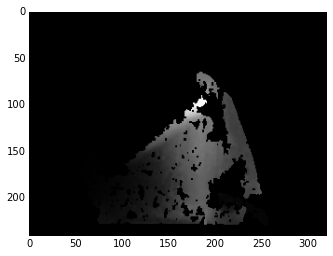

In [26]:
d1d = -1*np.min(d1)+d1 + 1
d1e = d1d
d1f=d1e/np.max(d1e)
d1g = d1f.reshape(left[:,:,0].shape)
h,w = d1g.shape
pl.imshow(d1g[:h/2, :w/2], cmap=cm.Greys_r)

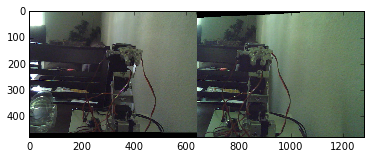

In [14]:
cam_2.StopCam()

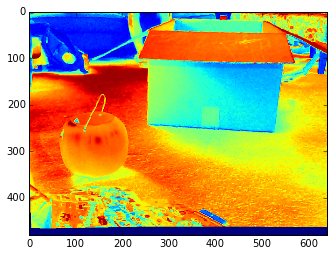

In [27]:
pl.imshow(cv2.cvtColor(left,cv2.COLOR_RGB2GRAY ))

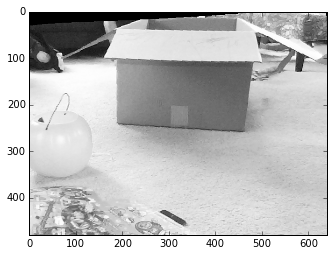

In [48]:
import matplotlib.cm as cm
pl.imshow(cv2.cvtColor(right,cv2.COLOR_RGB2GRAY ), cmap=cm.Greys_r)

In [46]:
cv2.imwrite('/home/karthik/tmp/left.jpg',cv2.cvtColor(left, cv2.COLOR_RGB2BGR))

True

In [47]:
cv2.imwrite('/home/karthik/tmp/right.jpg',cv2.cvtColor(right, cv2.COLOR_RGB2BGR))

True